# **Task 4: Ensemble Classifier**

### An ensamble classifier is obtained by combining the best models obtained on images and pointclouds.

In [1]:
# necessary imports
import os
import sys
import glob
import math
import numpy
import pandas
import random
import trimesh
import logging
import tensorflow
from numpy import argmax
from tensorflow.keras import models, layers, regularizers, optimizers, initializers, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input, ReLU

# do not truncate prints for debugging purposes
numpy.set_printoptions(threshold=sys.maxsize)

# import Stratified K-Fold Cross Validation notebook
%run KFold-Cross-Validation.ipynb

# dataset root path
DATASET_ROOT = '/run/media/rr/M2/DevOps/jupyter-lab/CIDL/dataset/'

# final preprocessed dataset directory path
DATASET_PATH = os.path.join(DATASET_ROOT, 'Preprocessed')

# saved experiments models path
IMAGES_SAVED_MODELS = '/run/media/rr/M2/DevOps/jupyter-lab/CIDL/project/saved_models/images'
POINTCLOUDS_SAVED_MODELS = '/run/media/rr/M2/DevOps/jupyter-lab/CIDL/project/saved_models/pointclouds'

# path where to save test results plots
save_path = '/run/media/rr/M2/DevOps/jupyter-lab/CIDL/project/saved_models/ensemble/ensemble'

# number of classes for the classification task
NUM_CLASSES = 5

In [2]:
# only log critical messages
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# **PointNet**

In [3]:
# COMMENT ME
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

# COMMENT ME
def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

# COMMENT ME
class OrthogonalRegularizer(regularizers.Regularizer):
    def __init__(self, num_features, l2=0.001):
        self.num_features = num_features
        self.eye = tensorflow.eye(num_features)
        self.l2 = l2

    def __call__(self, x):
        x = tensorflow.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tensorflow.tensordot(x, x, axes=(2, 2))
        xxt = tensorflow.reshape(xxt, (-1, self.num_features, self.num_features))
        return tensorflow.reduce_sum(self.l2 * tensorflow.square(xxt - self.eye))
    
    def get_config(self):
        return {'l2': float(self.l2), 'num_features': int(self.num_features)}

# COMMENT ME
def tnet(inputs, num_features):
    # Initalise bias as the indentity matrix
    bias = tensorflow.keras.initializers.Constant(numpy.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)

    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

# **Ensemble**

Found 1180 validated image filenames belonging to 5 classes.


2022-02-17 17:16:24.898781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 17:16:24.917248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 17:16:24.917363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 17:16:24.917927: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 1180 validated pointcloud filenames belonging to 5 classes.


2022-02-17 17:17:18.094174: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2022-02-17 17:17:19.128465: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Confusion Matrix
Normalized confusion matrix


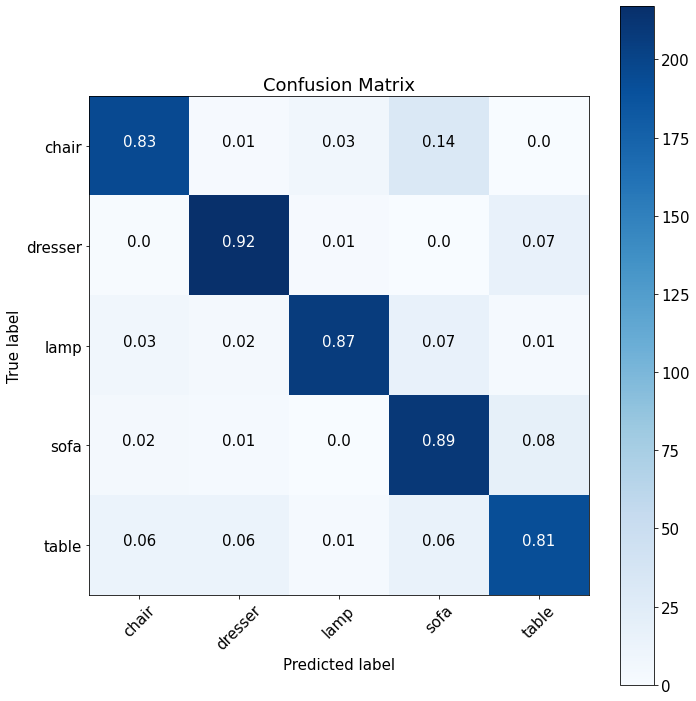

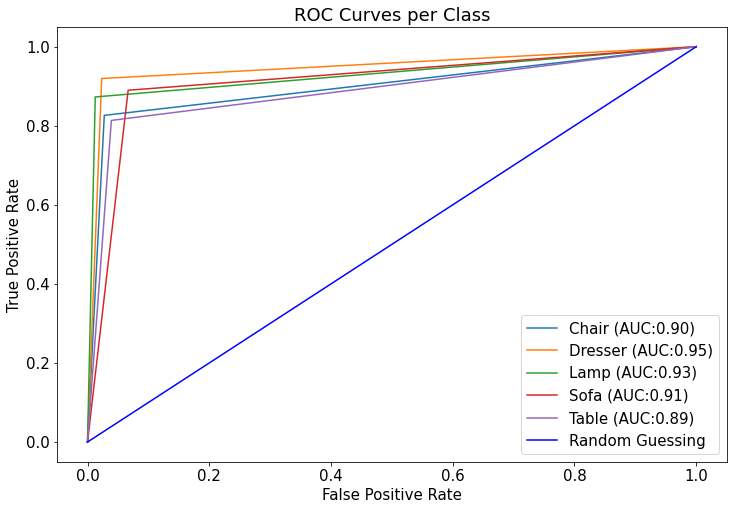

ROC AUC score: 0.9152542372881356
Classification Report
              precision    recall  f1-score   support

       chair       0.88      0.83      0.85       236
     dresser       0.91      0.92      0.91       236
        lamp       0.94      0.87      0.91       236
        sofa       0.77      0.89      0.83       236
       table       0.84      0.81      0.83       236

    accuracy                           0.86      1180
   macro avg       0.87      0.86      0.87      1180
weighted avg       0.87      0.86      0.87      1180



In [4]:
# parameters
batch_size = 32

# load images csv file
images_test_data = pandas.read_csv(os.path.join(DATASET_PATH, 'test_images.csv'))

# extract images path and class labels
images_test_X = images_test_data[['filename']]
images_test_Y = images_test_data[['class_label']]

# for transfer learning models do not rescale the testing data
test_image_data_generator = ImageDataGenerator()
test_data_generator  = test_image_data_generator.flow_from_dataframe(images_test_data, directory=None,
                                                        x_col="filename", y_col="class_label",
                                                        class_mode="categorical", shuffle=False,
                                                        target_size=(128, 128), batch_size=batch_size)

# load images models
images_model = tensorflow.keras.models.load_model('/run/media/rr/M2/DevOps/jupyter-lab/CIDL/project/saved_models/images/Experiment-14-2/Experiment-14-2-fold-1.h5')

# load test pointclouds csv file
pointclouds_test_data = pandas.read_csv(os.path.join(DATASET_PATH, 'test_pointclouds.csv'))

# extract images path and class labels
pointclouds_test_X = pointclouds_test_data[['filename']]
pointclouds_test_Y = pointclouds_test_data[['class_label']]

# test data arrays
test_pointclouds = []
test_labels = []
test_string_labels = {}

# test split ready
for index, test_data_row in pointclouds_test_data.iterrows():
    test_sampled_mesh = trimesh.load(test_data_row['filename'], force='mesh').sample(2048)
    test_normalized_mesh = test_sampled_mesh - numpy.mean(test_sampled_mesh, axis=0) 
    test_normalized_mesh /= numpy.max(numpy.linalg.norm(test_normalized_mesh, axis=1))
    test_pointclouds.append(test_normalized_mesh)
    test_labels.append(class_labels_dict[test_data_row['class_label']])
    test_string_labels[index] = test_data_row['class_label']

# convert to numpy array
test_pointclouds = numpy.array(test_pointclouds)
test_labels = numpy.array(test_labels)

# create test tf.data.Dataset
test_dataset = tensorflow.data.Dataset.from_tensor_slices((test_pointclouds, test_labels))
test_dataset = test_dataset.batch(batch_size)
print("Found " + str(len(pointclouds_test_data)) + " validated pointcloud filenames belonging to " + str(len(pointclouds_test_data['class_label'].unique())) + " classes.")

# load pointclouds model
pointclouds_model = tensorflow.keras.models.load_model('/run/media/rr/M2/DevOps/jupyter-lab/CIDL/project/saved_models/pointclouds/PointNet-9/PointNet-9-fold-1.h5',
                                                       custom_objects={"OrthogonalRegularizer": OrthogonalRegularizer})

# make predictions
images_predictions = images_model.predict(test_data_generator, batch_size=batch_size)
pointclouds_predictions = pointclouds_model.predict(test_dataset, batch_size=batch_size)

# merge images and pointclouds results
summed_predictions = numpy.sum([images_predictions, pointclouds_predictions], axis=0)
y_pred = numpy.argmax(summed_predictions, axis=-1)

# print report
print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)
plot_confusion_matrix(cm, class_labels_dict.keys(), save_path, title='Confusion Matrix')

# Plot ROC curve per class and print AUC score
print('ROC AUC score:', multiclass_roc_auc_score(save_path, test_labels, y_pred))

# print Classification Report
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=class_labels_dict.keys()))